### 2016 - 2020 Presidential Election Comparison

In [140]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [23]:
def print_df_overview(df, title):        
    print(f"{title} DF Head:")
    print(df.head())
    print("----------------------------------")
    print(f"{title} DF dtypes:")
    print(df.dtypes)
    
    for col in df.columns:
        print("----------------------------------")
        print(f"{title} DF column value counts:")

        ABRIDGED_ROWS = 16
        counts = df[col].value_counts()
        if counts.size < 2*ABRIDGED_ROWS:
            # Print the counts all together
            print(col, "counts:")    
            print(counts)
        else:
            # Print top and bottom counts
            print(col, "top counts:")
            print(counts[0:ABRIDGED_ROWS])
            print(col, "bottom counts:")
            print(counts[-ABRIDGED_ROWS:])

In [24]:
# The data files are too big to naively manage in git, so they are stored as zip files.
def unzip(zip, where):
    with ZipFile(zip, 'r') as zObject:   
        print(f"Unzipping {zip} to {where}")
        zObject.extractall(path=where) 
        
path_2016 = os.path.join('.', 'resources', '2016')
path_2016_csv = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv')
path_2016_zip = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv.zip')
path_2020 = os.path.join('.', 'resources', '2020')
path_2020_csv = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv')
path_2020_zip = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv.zip')

unzip(path_2016_zip, path_2016)
unzip(path_2020_zip, path_2020)

Unzipping .\resources\2016\2016-precinct-president.csv.zip to .\resources\2016
Unzipping .\resources\2020\PRESIDENT_precinct_general.csv.zip to .\resources\2020


In [25]:
# Read raw data -- takes several seconds

# Encoding wasn't documented but ISO-8859-1 seems to work fine. 
# Some data types specified here to suppress warnings -- they're actually provided for 2020
raw_2016_df = pd.read_csv(path_2016_csv, encoding="ISO-8859-1", 
                          dtype={"precinct":str, "district":str, "party":str, "candidate_fec":str, "candidate_fec_name":str, "votes":int} )

# These come straight from the data documentation:
official_2020_dtypes = {'precinct':str,'office':str, 'party_detailed':str, 
		'party_simplified':str,'mode':str,'votes':int, 'county_name':str,
		'county_fips':str, 'jurisdiction_name':str,'jurisdiction_fips':str,
		'candidate':str, 'district':str, 'dataverse':str,'year':int,
		'stage':str, 'state':str, 'special':str, 'writein':str, 'state_po':str,
		'state_fips':str, 'state_cen':str, 'state_ic':str, 'date':str, 
		'readme_check':str,'magnitude':int}
raw_2020_df = pd.read_csv(path_2020_csv, encoding="ISO-8859-1", dtype=official_2020_dtypes )

raw_2016_df.shape, raw_2020_df.shape

((1989234, 37), (1982581, 25))

In [26]:
# Get ready to clean up
c_2016_df = raw_2016_df.copy()
c_2020_df = raw_2020_df.copy()
print("Initial:                 ", c_2016_df.shape, c_2020_df.shape)

# Results include "statistial adjustments" which I'm ignoring for the moment
c_2016_df = c_2016_df.drop(c_2016_df[c_2016_df.precinct == "Statistical Adjustments"].index)
c_2020_df = c_2020_df.drop(c_2020_df[c_2020_df.jurisdiction_name == "{STATISTICAL ADJUSTMENTS}"].index)
print("Drop adjustments:        ", c_2016_df.shape, c_2020_df.shape)

# Also remove any negative votes -- I don't know what they mean
c_2016_df = c_2016_df.drop(c_2016_df[c_2016_df.votes < 0].index)
c_2020_df = c_2020_df.drop(c_2020_df[c_2020_df.votes < 0].index)
print("Drop negative votes:     ", c_2016_df.shape, c_2020_df.shape)

# Narrow down to the interesting columns.
#c_2016_df = c_2016_df.loc[:, ["state", "county_name", "jurisdiction", "candidate", "votes"] ]
c_2016_df = c_2016_df.loc[:, ["state", "county_name", "candidate", "votes"] ]
#c_2020_df = c_2020_df.loc[:, ["state", "county_name", "jurisdiction_name", "candidate", "votes"] ]
c_2020_df = c_2020_df.loc[:, ["state", "county_name", "candidate", "votes"] ]
print("Drop extraneous columns: ", c_2016_df.shape, c_2020_df.shape)

# Change a couple column names for consistency and conciseness
c_2016_df.rename(columns={"county_name": "county"}, inplace=True)
c_2020_df.rename(columns={"county_name": "county"}, inplace=True)
#c_2020_df.rename(columns={"jurisdiction_name": "jurisdiction"}, inplace=True)

# 2016 uses normal capitalization while 2020 uses all caps
# So, California vs CALIFORNIA, and District of Columbia vs DISTRICT OF COLUMBIA
# To reconcile them, force everything to lowercase.
c_2016_df["state"] = c_2016_df["state"].str.lower()
c_2016_df["county"] = c_2016_df["county"].str.lower()
#c_2016_df["jurisdiction"] = c_2016_df["jurisdiction"].str.lower()
c_2016_df["candidate"] = c_2016_df["candidate"].str.lower()
c_2020_df["state"] = c_2020_df["state"].str.lower()
c_2020_df["county"] = c_2020_df["county"].str.lower()
#c_2020_df["jurisdiction"] = c_2020_df["jurisdiction"].str.lower()
c_2020_df["candidate"] = c_2020_df["candidate"].str.lower()

# County names actually say "county" in the 2016 data, so remove that
c_2016_df["county"] = c_2016_df["county"].str.replace(" county", "")

# Reconcile candidate names. Clinton and Biden are equivalent for our purposes, 
# and Biden and Trump both appear in multiple forms in the datasets.
# Any other candidate is just "other".
dem_names = ["hillary clinton", "biden, joe", "joseph biden", "joseph r biden"]
rep_names = ["donald trump", "donald j trump"]
combo = dem_names + rep_names
c_2016_df.loc[~c_2016_df["candidate"].isin(combo), "candidate"] = "other"
c_2020_df.loc[~c_2020_df["candidate"].isin(combo), "candidate"] = "other"
c_2016_df.loc[c_2016_df["candidate"].isin(dem_names), "candidate"] = "the dem"
c_2016_df.loc[c_2016_df["candidate"].isin(rep_names), "candidate"] = "trump"
c_2020_df.loc[c_2020_df["candidate"].isin(dem_names), "candidate"] = "the dem"
c_2020_df.loc[c_2020_df["candidate"].isin(rep_names), "candidate"] = "trump"

print("2016:")
raw_rows = raw_2016_df.shape[0]
raw_votes = raw_2016_df['votes'].sum()
clean_rows = c_2016_df.shape[0]
clean_votes = c_2016_df['votes'].sum()
print(f"Original: {raw_rows:7} rows, {raw_votes:10} votes")
print(f"Cleaned:  {clean_rows:7} rows, {clean_votes:10} votes -- {clean_rows / raw_rows:.3%} and {clean_votes / raw_votes:.3%}")

print("2020:")
raw_rows = raw_2020_df.shape[0]
raw_votes = raw_2020_df['votes'].sum()
clean_rows = c_2020_df.shape[0]
clean_votes = c_2020_df['votes'].sum()
print(f"Original: {raw_rows:7} rows, {raw_votes:10} votes")
print(f"Cleaned:  {clean_rows:7} rows, {clean_votes:10} votes -- {clean_rows / raw_rows:.3%} and {clean_votes / raw_votes:.3%}")

Initial:                  (1989234, 37) (1982581, 25)
Drop adjustments:         (1988506, 37) (1982207, 25)
Drop negative votes:      (1988502, 37) (1974972, 25)
Drop extraneous columns:  (1988502, 4) (1974972, 4)
2016:
Original: 1989234 rows,  140070880 votes
Cleaned:  1988502 rows,  140064901 votes -- 99.963% and 99.996%
2020:
Original: 1982581 rows,  157743486 votes
Cleaned:  1974972 rows,  157753369 votes -- 99.616% and 100.006%


In [27]:
#print_df_overview(c_2016_df, "2016 Cleaned")
#print_df_overview(c_2020_df, "2020 Cleaned")
c_2016_df, c_2020_df

(           state   county candidate  votes
 0        alabama  autauga   the dem    135
 1        alabama  autauga     other      0
 2        alabama  autauga     other      1
 3        alabama  autauga     trump    218
 4        alabama  autauga     other      4
 ...          ...      ...       ...    ...
 1989229  wyoming   weston   the dem     63
 1989230  wyoming   weston     other      0
 1989231  wyoming   weston     other     28
 1989232  wyoming   weston     other      2
 1989233  wyoming   weston     trump    412
 
 [1988502 rows x 4 columns],
               state   county candidate  votes
 0        california  ventura     other      0
 1        california  ventura   the dem      1
 2        california  ventura     other      0
 3        california  ventura     other      0
 4        california  ventura     other      0
 ...             ...      ...       ...    ...
 1982576  california     yolo     trump   1558
 1982577  california     yolo     other      2
 1982578  californ

In [104]:
# Combine the dataframes, with each year getting its own column for votes
ldf = pd.DataFrame(c_2016_df.groupby(["state", "county", "candidate"])["votes"].sum())
rdf = pd.DataFrame(c_2020_df.groupby(["state", "county", "candidate"])["votes"].sum())
combo_df = pd.merge(ldf, rdf, on=["state", "county", "candidate"], suffixes=["_2016", "_2020"])
combo_df.reset_index(inplace=True)

print_df_overview(combo_df, "Combo DF")

# Save to CSV to enable some manual sanity checks
combo_df.to_csv("combined.csv")

Combo DF DF Head:
     state   county candidate  votes_2016  votes_2020
0  alabama  autauga     other       12892         516
1  alabama  autauga   the dem        5936        7503
2  alabama  autauga     trump       18172       19838
3  alabama  baldwin     other       55584        1890
4  alabama  baldwin   the dem       18458       24578
----------------------------------
Combo DF DF dtypes:
state         object
county        object
candidate     object
votes_2016     int64
votes_2020     int64
dtype: object
----------------------------------
Combo DF DF column value counts:
state top counts:
state
texas             762
georgia           477
virginia          399
kentucky          360
missouri          324
kansas            315
illinois          303
north carolina    300
iowa              297
tennessee         285
nebraska          279
ohio              264
minnesota         258
mississippi       246
michigan          243
oklahoma          231
Name: count, dtype: int64
state bottom c

In [172]:
# Build up states and nontrivial counties, adding vote totals columns too
combo_df["total_2016"] = ""
combo_df["total_2020"] = ""

for state in combo_df["state"].unique():
    state_slice = combo_df.loc[combo_df["state"] == state]
    counties = state_slice["county"].unique()
    for county in counties:
        county_slice = state_slice.loc[combo_df["county"] == county]        
        total_2016 = county_slice["votes_2016"].sum()
        total_2020 = county_slice["votes_2020"].sum()

        combo_df.loc[county_slice.index, "total_2016"] = total_2016
        combo_df.loc[county_slice.index, "total_2020"] = total_2020

        if (total_2016 > 1000 and total_2020 > 1000):
            care_counties.append(county)

combo_df

({'alabama': ['autauga',
   'baldwin',
   'barbour',
   'bibb',
   'blount',
   'bullock',
   'butler',
   'calhoun',
   'chambers',
   'cherokee',
   'chilton',
   'choctaw',
   'clarke',
   'clay',
   'cleburne',
   'coffee',
   'colbert',
   'conecuh',
   'coosa',
   'covington',
   'crenshaw',
   'cullman',
   'dale',
   'dallas',
   'dekalb',
   'elmore',
   'escambia',
   'etowah',
   'fayette',
   'franklin',
   'geneva',
   'greene',
   'hale',
   'henry',
   'houston',
   'jackson',
   'jefferson',
   'lamar',
   'lauderdale',
   'lawrence',
   'lee',
   'limestone',
   'lowndes',
   'macon',
   'madison',
   'marengo',
   'marion',
   'marshall',
   'mobile',
   'monroe',
   'montgomery',
   'morgan',
   'perry',
   'pickens',
   'pike',
   'randolph',
   'russell',
   'shelby',
   'sumter',
   'talladega',
   'tallapoosa',
   'tuscaloosa',
   'walker',
   'washington',
   'wilcox',
   'winston'],
  'arizona': ['apache',
   'cochise',
   'coconino',
   'gila',
   'graham',
  

In [106]:
# Add the columns showing percentages and changes from 2016-2020
combo_df["pct_2016"] = combo_df["votes_2016"] / combo_df["total_2016"]
combo_df["pct_2020"] = combo_df["votes_2020"] / combo_df["total_2020"]
combo_df["votes_change"] = combo_df["votes_2020"] - combo_df["votes_2016"]
combo_df["pct_change"] = combo_df["pct_2020"] - combo_df["pct_2016"]

combo_df

,state,county,candidate,votes_2016,votes_2020,total_2016,total_2020,pct_2016,pct_2020,votes_change,pct_change
0,alabama,autauga,other,12892,516,37000,27857,0.348432,0.018523,-12376,-0.329909
1,alabama,autauga,the dem,5936,7503,37000,27857,0.160432,0.26934,1567,0.108907
2,alabama,autauga,trump,18172,19838,37000,27857,0.491135,0.712137,1666,0.221002
3,alabama,baldwin,other,55584,1890,146925,110012,0.378315,0.01718,-53694,-0.361136
4,alabama,baldwin,the dem,18458,24578,146925,110012,0.125629,0.223412,6120,0.097783
...,...,...,...,...,...,...,...,...,...,...,...
8954,wyoming,washakie,the dem,532,651,3814,4032,0.139486,0.161458,119,0.021972
8955,wyoming,washakie,trump,2911,3245,3814,4032,0.763241,0.804812,334,0.041571
8956,wyoming,weston,other,194,93,3526,3560,0.05502,0.026124,-101,-0.028896
8957,wyoming,weston,the dem,299,360,3526,3560,0.084799,0.101124,61,0.016325


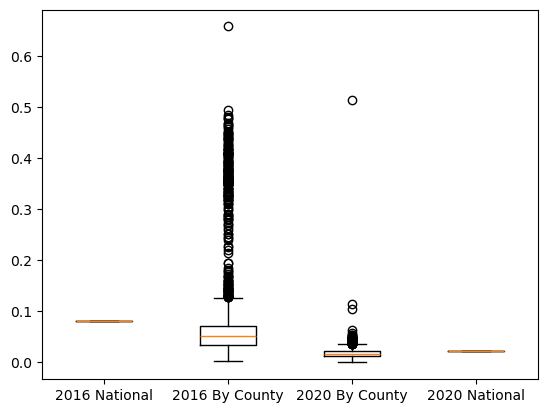

In [171]:
# Show national and county stats for percentage voting for "other"
national_gb = combo_df.groupby("candidate").sum()
national_pct_2016 = national_pct["votes_2016"].sum()["other"] / national_pct["votes_2016"].sum().sum()
national_pct_2020 = national_pct["votes_2020"].sum()["other"] / national_pct["votes_2016"].sum().sum()

others_slice = combo_df.loc[combo_df["candidate"] == "other"]
#plt.boxplot([others_slice["pct_2016"], others_slice["pct_2020"]], tick_labels=["2016", "2020"])
plt.boxplot(
        [[national_pct_2016], others_slice["pct_2016"], others_slice["pct_2020"], national_pct_2020],
        tick_labels = ["2016 National", "2016 County",  "2020 County", "2020 National"])
plt.show()
